In [1]:
# get one seller Q leaning to work
# print table nicelya to a
# llow diagnosing issues
# get twoseller Q learning to wokr
# get one seller Q learning with normal maxprice generation to work
# get two seller Q learning with normal maxprice to work
# get two seller Q learning with taking competitor offer into account to work

In [ ]:
# make it optimize over many rounds

# One Seller Q learning

In [11]:
from sellers import Seller

In [12]:
import random
class QLearningSeller(Seller):
  def __init__(self, value, init_offer):
    super().__init__(value, init_offer)
    action_space_size = self.init_offer - self.value
    state_space_size = (self.init_offer - self.value) ** 2
    self.q_table = np.zeros((state_space_size, action_space_size))

    # Q-Learning parameters
    # alpha
    self.learning_rate = 0.1
    # gamma
    self.discount_rate = 0.99
    # exploration rate for when the model is still learning
    self.exploration_rate = .15

    # # unused variables for a changing exploration rate
    # self.max_exploration_rate = 1
    # self.min_exploration_rate = 0.01
    # self.exploration_decay_rate = 0.001

  def make_offer(self):
    random_number = random.uniform(0, 1)
    if random_number > self.exploration_rate:
      print(self.q_table[self.get_state_array_number(self.state), :])
      offer = np.argmax(self.q_table[self.get_state_array_number(self.state), :]) + (self.value+1)
    else: #exploring
      offer = random.randint(self.value+1,self.state['last-offer']-1)
    return offer

  def update_table(self, offer, decision, new_state):
    if decision == 'accept offer':
      reward = offer - self.value
    else:
      reward = 0
    state_array_number = self.get_state_array_number(self.state)
    new_state_array_number = self.get_state_array_number(new_state)
    self.q_table[state_array_number, offer-(self.value+1)] = self.q_table[state_array_number, offer-(self.value+1)] * (1 - self.learning_rate) + \
                                  self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state_array_number, :]))

  # helper methods
  def get_state_array_number(self, state):
    return state['last-offer']-(self.value+1)+(self.init_offer-self.value)*state['offers-made']

  def from_array_num_get_state(self, array_num):
    offers_made = math.floor(array_num/(self.init_offer-self.value))
    last_offer =  array_num % (self.init_offer-self.value) + (self.value + 1)
    return {"last-offer":last_offer, "offers-made":offers_made}

  def set_exploiting(self):
    self.exploration_rate = 0

# Two sellers

In [2]:
#buyer for two or more sellers
class EducatedBuyer(object):
    def __init__(self, max_price, imp_incr):
        self.max_price = max_price
        self.imp = 0
        self.imp_incr = imp_incr

    def check_all_offers(self, offers):
        decisions = [] # saves decision for each offer
        accept_indices = [] # saves indices of accepted offers
        accept_values = [] # saves values of accepted offers

        random_number = random.uniform(0, 1)
        if random_number <= self.imp:
            for i in range(len(offers)):
                decisions.append("walk away")
        else:
            for i, offer in enumerate(offers):
                if offer <= self.max_price:
                    decisions.append("accept offer")
                    accept_indices.append(i)
                    accept_values.append(offer)
                else:
                    decisions.append("reject but continue")

        # if more than one offer is accepted
        # NEED OT CHANGE REJECT BUT CONTINUE TO COMPETITOR WON OUT IF THERE ARE ANY ACCEPTS AT ALL
        if len(accept_indices) > 0:
            min_value = min(accept_values)
            min_indices = [i for i, value in zip(accept_indices, accept_values) if value == min_value]

            if len(min_indices) > 1:
                # randomly choose an offer to accept if there are multiple offers with the minimum value
                accept_index = random.choice(min_indices)
            else:
                # if there is a unique minimum, accept it
                accept_index = min_indices[0]
            for idx in range(len(decisions)):
              if idx == accept_index:
                decisions[idx] = "accept offer"
              else:
                decisions[idx] = "competitor won"

        self.imp += self.imp_incr
        return decisions

In [4]:
from sellers import RandomSeller
import random

range_min = 11
range_max = 30
value = 10
rounds = 10
imp_incr = 0.1

init_offer = range_max

random_seller = RandomSeller(value=value, init_offer=init_offer)
qseller = RandomSeller(value=value, init_offer=init_offer)
sellers = [random_seller, qseller]

total_profits = [0 for i in range(len(sellers))]
for i in range(rounds):
  maxprice = random.randint(range_min, range_max)
  edubuyer = EducatedBuyer(maxprice, imp_incr)
  profits = two_seller_negotiation(edubuyer, sellers, False)
  for i in range(len(sellers)):
    total_profits[i] += profits[i]
print(total_profits)


NameError: name 'two_seller_negotiation' is not defined

In [15]:
import random
import json
import pandas as pd

class UpdatedQLearningSeller(Seller):
    def __init__(self, value, init_offer):
        super().__init__(value, init_offer)
        self.q_dict = {}

        self.learning_rate = .1
        self.discount_rate = 1
        self.exploration_rate = .1

    def make_offer(self):
        random_number = random.uniform(0, 1)
        state = (self.state['last-offer'], self.state['offers-made'])
        if random_number > self.exploration_rate:
          if state in self.q_dict and self.q_dict[state]:  # checking if state is a valid key and the corresponding dictionary is not empty
            offer = max(self.q_dict[state], key=self.q_dict[state].get) + (self.value + 1)
          else:  # you can define a default behavior when the state is not in the Q-table yet
            offer = random.randint(self.value+1, self.state['last-offer'])
        else:
            offer = random.randint(self.value+1, self.state['last-offer'])
        return offer

    def update_table(self, offer, decision, new_state):
        reward = offer - self.value if decision == 'accept offer' else 0
        state = (self.state['last-offer'], self.state['offers-made'])
        new_state = (new_state['last-offer'], new_state['offers-made'])
        action = offer

        old_q_value = self.q_dict.get(state, {}).get(action, 0)
        max_new_state_q_value = max(self.q_dict.get(new_state, {}).values(), default=0)
        new_q_value = (1 - self.learning_rate) * old_q_value + self.learning_rate * (reward + self.discount_rate * max_new_state_q_value)

        if state not in self.q_dict:
            self.q_dict[state] = {}

        self.q_dict[state][action] = new_q_value

    def set_exploiting(self):
        self.exploration_rate = 0

    def give_table(self):
        # convert the q_dict to a DataFrame
        df = pd.DataFrame(self.q_dict).T
        return df



# Q learning two sellers

In [147]:
def two_seller_negotiation(edubuyer, sellers, verbose = False):
  # assume 2 sellers
  terminate = False
  if verbose:
    print(f"buyer maxprice: {edubuyer.max_price}")
    for i, seller  in enumerate(sellers):
      print(f"seller{i} state: {seller.state}")
    print()
  while not terminate:

    offers = [seller.make_offer() for seller in sellers]
    decisions = edubuyer.check_all_offers(offers)
    terminate = ("walk away" in decisions or "accept offer" in decisions)
    # this kind of a junky way to code it
    # but it works for now
    for i, seller in enumerate(sellers):
      new_state = {"last-offer":offers[i],
                  "comp-last-offer":(offers[:i] + offers[i+1:])[0],
                  "offers-made":seller.state["offers-made"]+1}
      seller.update_table(offers[i], decisions[i], new_state)
      seller.state = new_state

      if verbose:
        print(f"seller{i} state: {seller.state}")
        print(f"decision {decisions[i]}")

    if verbose:
      print()


  # get reward for the agents if terminated
  profits = [None for i in range(len(sellers))]
  for i, seller in enumerate(sellers):
    if decisions[i] == "accept offer":
      profits[i]=seller.state["last-offer"]-seller.value
    elif decisions[i] == "walk away":
      profits[i]=0
    elif decisions[i] == "competitor won":
      profits[i]=0
  for seller in sellers:
    seller.reset_state()
  return profits

In [148]:
import random
from sellers import Seller
import numpy as np
import math

class OldQLearningSeller(Seller):
  def __init__(self, value, init_offer):
    super().__init__(value, init_offer)
    action_space_size = self.init_offer - self.value
    state_space_size = (self.init_offer - self.value) ** 2
    self.q_table = np.zeros((state_space_size, action_space_size))

    # Q-Learning parameters
    # alpha
    self.learning_rate = 0.1
    # gamma
    self.discount_rate = 0.99
    # exploration rate for when the model is still learning
    self.exploration_rate = .01

    # # unused variables for a changing exploration rate
    # self.max_exploration_rate = 1
    # self.min_exploration_rate = 0.01
    # self.exploration_decay_rate = 0.001

  def make_offer(self):
    random_number = random.uniform(0, 1)
    if random_number > self.exploration_rate:
      #print(self.q_table[self.get_state_array_number(self.state), :])
      offer = np.argmax(self.q_table[self.get_state_array_number(self.state), :]) + (self.value+1)
    else: #exploring
      offer = random.randint(self.value+1,self.state['last-offer']-1)
    return offer

  def update_table(self, offer, decision, new_state):
    if decision == 'accept offer':
      reward = offer - self.value
    else:
      reward = 0
    state_array_number = self.get_state_array_number(self.state)
    new_state_array_number = self.get_state_array_number(new_state)
    self.q_table[state_array_number, offer-(self.value+1)] = self.q_table[state_array_number, offer-(self.value+1)] * (1 - self.learning_rate) + \
                                  self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state_array_number, :]))

  # helper methods
  def get_state_array_number(self, state):
    return state['last-offer']-(self.value+1)+(self.init_offer-self.value)*state['offers-made']

  def from_array_num_get_state(self, array_num):
    offers_made = math.floor(array_num/(self.init_offer-self.value))
    last_offer =  array_num % (self.init_offer-self.value) + (self.value + 1)
    return {"last-offer":last_offer, "offers-made":offers_made}

  def set_exploiting(self):
    self.exploration_rate = 0

In [204]:
import random
from sellers import Seller
import numpy as np
import math

class QLearningSeller(Seller):
  def __init__(self, value, init_offer):
    super().__init__(value, init_offer)
    self.q_table = {}

    # Q-Learning parameters
    # alpha
    self.learning_rate = 0.1
    # gamma
    self.discount_rate = 0.99
    # exploration rate for when the model is still learning
    self.exploration_rate = 1
    self.init_learning_rate =1
    self.learning_rate_decay = 0.0001
    self.total_offers_made = 0  # Add a new instance variable to keep track of the total number of offers made across all episodes
    self.init_exploration_rate = 1.0  # Maximum exploration rate
    self.min_exploration_rate = 0.001  # Minimum exploration rate
    self.exploration_decay_rate = 0.00001  # Exponential decay rate for exploration probability


  def make_offer(self):
    state_tuple = (self.state['last-offer'], self.state['offers-made'])
    random_number = random.uniform(0, 1)
    if random_number > self.exploration_rate:
      # Check if state exists in q_table and if not, create it
      if state_tuple not in self.q_table:
          self.q_table[state_tuple] = {}
      # Get the action that has the highest q value
      offer = max(self.q_table[state_tuple], key=self.q_table[state_tuple].get, default=self.value+1)
    else: #exploring
      offer = random.randint(self.value+1,self.state['last-offer']-1)
    self.total_offers_made += 1  # Increment the total number of offers made every time an offer is made
    return offer

  def update_table(self, offer, decision, new_state):
    old_state_tuple = (self.state['last-offer'], self.state['offers-made'])
    new_state_tuple = (new_state['last-offer'], new_state['offers-made'])
    if decision == 'accept offer':
      reward = offer - self.value
    else:
      reward = 0
    # Ensure current state and new state are in the q_table
    if old_state_tuple not in self.q_table:
      self.q_table[old_state_tuple] = {}
    if new_state_tuple not in self.q_table:
      self.q_table[new_state_tuple] = {}

    old_value = self.q_table[old_state_tuple].get(offer, 0)
    max_new_state_value = max(self.q_table[new_state_tuple].values(), default=0)

    self.q_table[old_state_tuple][offer] = old_value * (1 - self.learning_rate) + \
      self.learning_rate * (reward + self.discount_rate * max_new_state_value)

  def get_optimal_policy(self, state):
      optimal_policy = []

      # Loop until a terminal state is reached or a state-action pair not in the Q-table is found
      while state in self.q_table and self.q_table[state]:
          action = max(self.q_table[state], key=self.q_table[state].get)
          optimal_policy.append((state, action))
          # Update state, assuming action results in a decreased 'last-offer' and increased 'offers-made'
          state = (action, state[1]+1)
      return optimal_policy

  def set_exploiting(self):
    self.exploration_rate = 0

  def get_learning_rate(self):
    self.learning_rate = self.init_learning_rate / (1 + self.learning_rate_decay * self.total_offers_made)


  def reset_state(self):
    super().reset_state()
    self.learning_rate = self.init_learning_rate / (1 + self.learning_rate_decay * self.total_offers_made)
    self.get_learning_rate()
    self.exploration_rate = self.min_exploration_rate + \
      (self.init_exploration_rate - self.min_exploration_rate) * \
      np.exp(-self.exploration_decay_rate * self.total_offers_made)


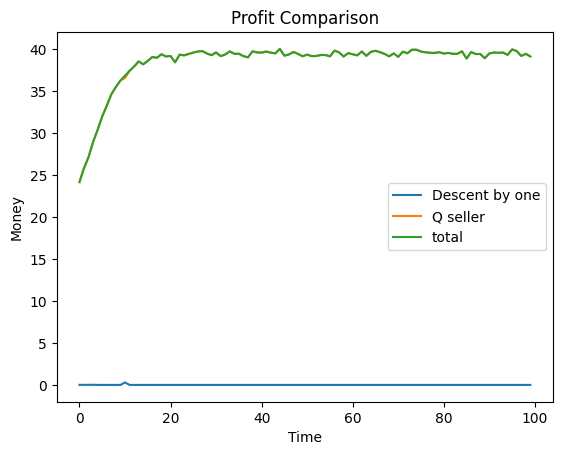

In [206]:
from buyers import EducatedBuyer
import matplotlib.pyplot as plt
from sellers import DescentArithmeticSeller
from sellers import DescentByNSeller

range_min = 11
range_max = 100
value = 10
rounds = 10000
imp_incr = 0

init_offer = range_max

random_seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent=1)
qseller = QLearningSeller(value=value, init_offer=init_offer)
sellers = [random_seller, qseller]

profits_random_seller = []
profits_q_seller = []

# Simulation of 100 rounds
for _ in range(100):
    total_profits = [0 for i in range(len(sellers))]
    for i in range(rounds):
        maxprice = int(random.uniform(range_min, range_max+1))
        edubuyer = EducatedBuyer(maxprice, imp_incr)
        profits = two_seller_negotiation(edubuyer, sellers, False)
        #print(qseller.q_table)
        for i in range(len(sellers)):
            total_profits[i] += profits[i] /rounds

    profits_random_seller.append(total_profits[0])
    profits_q_seller.append(total_profits[1])

# Plotting
fig, ax = plt.subplots()
ax.plot(profits_random_seller, label='Descent by one')
ax.plot(profits_q_seller, label='Q seller')
ax.plot([profits_q_seller[i]+profits_random_seller[i] for i in range(len(profits_q_seller))], label='total')
ax.set_xlabel('Time')
ax.set_ylabel('Money')
ax.set_title('Profit Comparison')
ax.legend()
plt.show()

In [207]:
qseller.exploration_rate

0.001000000000000222

In [208]:
optimal_policy = qseller.get_optimal_policy((100,0))
print(optimal_policy)

[((100, 0), 82), ((82, 1), 63), ((63, 2), 51), ((51, 3), 38), ((38, 4), 32), ((32, 5), 25), ((25, 6), 21), ((21, 7), 17), ((17, 8), 13), ((13, 9), 12), ((12, 10), 11)]


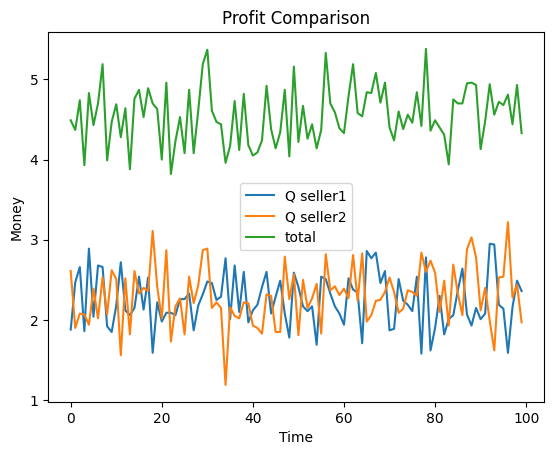

In [236]:
from buyers import EducatedBuyer
import matplotlib.pyplot as plt

range_min = 11
range_max = 30
value = 10
rounds = 100
imp_incr = 0.2

init_offer = range_max

qseller1 = QLearningSeller(value=value, init_offer=init_offer)
qseller2 = QLearningSeller(value=value, init_offer=init_offer)
sellers = [qseller1, qseller2]

profits_random_seller = []
profits_q_seller = []

# Simulation of 100 rounds
for _ in range(100):
    total_profits = [0 for i in range(len(sellers))]
    for i in range(rounds):
        maxprice = int(random.uniform(range_min, range_max+1))
        edubuyer = EducatedBuyer(maxprice, imp_incr)
        profits = two_seller_negotiation(edubuyer, sellers, False)
        #print(qseller.q_table)
        for i in range(len(sellers)):
            total_profits[i] += profits[i] /rounds

    profits_random_seller.append(total_profits[0])
    profits_q_seller.append(total_profits[1])

# Plotting
fig, ax = plt.subplots()
ax.plot(profits_random_seller, label='Q seller1')
ax.plot(profits_q_seller, label='Q seller2')
ax.plot([profits_q_seller[i]+profits_random_seller[i] for i in range(len(profits_q_seller))], label='total')
ax.set_xlabel('Time')
ax.set_ylabel('Money')
ax.set_title('Profit Comparison')
ax.legend()
plt.show()

In [237]:
optimal_policy = qseller1.get_optimal_policy((30,0))
print(optimal_policy)

[((30, 0), 17), ((17, 1), 15), ((15, 2), 14), ((14, 3), 11)]


In [238]:
optimal_policy = qseller2.get_optimal_policy((30,0))
print(optimal_policy)

[((30, 0), 29), ((29, 1), 21), ((21, 2), 14), ((14, 3), 12), ((12, 4), 11)]


# Normal price distribution

In [253]:
import numpy as np
import matplotlib.pyplot as plt
def show_histogram(mean, stdev):
  num_samples = 1000
  samples_float = np.random.normal(mean, stdev, num_samples)
  samples = np.round(samples_float).astype(int)
  plt.hist(samples, bins=20, density=True)
  plt.show()

def sample_one_point(mean, stdev):
  num_samples = 1
  samples_float = np.random.normal(mean, stdev, num_samples)
  samples = np.round(samples_float).astype(int)
  return samples[0]

In [ ]:
import random
from sellers import Seller
import numpy as np
import math

class QLearningSeller(Seller):
  def __init__(self, value, init_offer):
    super().__init__(value, init_offer)
    action_space_size = self.init_offer - self.value
    state_space_size = (self.init_offer - self.value) ** 2
    self.q_table = np.zeros((state_space_size, action_space_size))

    # Q-Learning parameters
    # alpha
    self.learning_rate = 0.1
    # gamma
    self.discount_rate = 0.99
    # exploration rate for when the model is still learning
    self.exploration_rate = .01

    # # unused variables for a changing exploration rate
    # self.max_exploration_rate = 1
    # self.min_exploration_rate = 0.01
    # self.exploration_decay_rate = 0.001

  def make_offer(self):
    random_number = random.uniform(0, 1)
    if random_number > self.exploration_rate:
      #print(self.q_table[self.get_state_array_number(self.state), :])
      offer = np.argmax(self.q_table[self.get_state_array_number(self.state), :]) + (self.value+1)
    else: #exploring
      offer = random.randint(self.value+1,self.state['last-offer']-1)
    return offer

  def update_table(self, offer, decision, new_state):
    if decision == 'accept offer':
      reward = offer - self.value
    else:
      reward = 0
    state_array_number = self.get_state_array_number(self.state)
    new_state_array_number = self.get_state_array_number(new_state)
    self.q_table[state_array_number, offer-(self.value+1)] = self.q_table[state_array_number, offer-(self.value+1)] * (1 - self.learning_rate) + \
                                  self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state_array_number, :]))

  # helper methods
  def get_state_array_number(self, state):
    return state['last-offer']-(self.value+1)+(self.init_offer-self.value)*state['offers-made']

  def from_array_num_get_state(self, array_num):
    offers_made = math.floor(array_num/(self.init_offer-self.value))
    last_offer =  array_num % (self.init_offer-self.value) + (self.value + 1)
    return {"last-offer":last_offer, "offers-made":offers_made}

  def set_exploiting(self):
    self.exploration_rate = 0